In [1]:
import os
import scipy
import numpy as np
import pandas as pd
from pathlib import Path
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn import set_config
set_config(display = 'diagram')
from pandas.api.types import infer_dtype


# Scikit Learn import
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.pipeline import FeatureUnion
# from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn import cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor


# Category Encoder
import category_encoders as ce
# pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA as PCA_pyod
from pyod.models.mcd import MCD
from pyod.models.sod import SOD
from pyod.models.sos import SOS
# model
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE

import re

import vnquant.DataLoader as dl
from datetime import datetime, timedelta
import pytz
from pathlib import Path


## import nesse

In [30]:
init_date = str((datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')) - timedelta(days=365 + 365)).strftime("%Y-%m-%d"))
start_date = str((datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')) - timedelta(days=365)).strftime("%Y-%m-%d"))
end_date = str((datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')) - timedelta(days=0)).strftime("%Y-%m-%d"))

symbols = ["HSG", "HPG", "NKG"]
import unidecode
 
def remove_accent(text):
    return unidecode.unidecode(text)
def get_data_symbol(symbol, start_date = start_date, end_date = end_date):
    date_range = pd.DataFrame({'index': pd.date_range(start=start_date, end=end_date)})
    loader = dl.DataLoader(symbols=[symbol], start=start_date, end=end_date, minimal=True)
    data = loader.download()
    data.columns = [col[0] for col in data.columns]
    
    # Basic index report
    loader = dl.FinanceLoader(symbol, start = init_date, end = end_date, data_source='VND', minimal=True)
    data_basic = loader.get_basic_index()
    data_basic = data_basic.T.sort_index()
    data_basic.index = pd.to_datetime(data_basic.index)
    date_range = pd.DataFrame({'index': pd.date_range(start=data_basic.index.min(), end=end_date)})
    data_basic = date_range.set_index('index').join(data_basic).fillna(method = 'ffill')
    data = data.join(data_basic, how = 'left')
    # finance report
    loader = dl.FinanceLoader(symbol, init_date, end_date)
    data_finan = loader.get_finan_report()
    data_finan = data_finan.T.sort_index()
    data_finan.index = pd.to_datetime(data_finan.index)
    date_range = pd.DataFrame({'index': pd.date_range(start=data_finan.index.min(), end=end_date)})
    data_finan = date_range.set_index('index').join(data_finan).fillna(method = 'ffill')
    data = data.join(data_finan, how = 'left')
    # business report
    data_bus = loader.get_business_report()
    data_bus = data_bus.T.sort_index()
    data_bus.index = pd.to_datetime(data_bus.index)
    date_range = pd.DataFrame({'index': pd.date_range(start=data_bus.index.min(), end=end_date)})
    data_bus = date_range.set_index('index').join(data_bus).fillna(method = 'ffill')
    data = data.join(data_bus, how = 'left')
    # cashflow report
    loader = dl.FinanceLoader(symbol, init_date, end_date, data_source='VND', minimal=True)
    data_cash = loader.get_cashflow_report()
    data_cash = data_cash.T.sort_index()
    data_cash.index = pd.to_datetime(data_cash.index)
    date_range = pd.DataFrame({'index': pd.date_range(start=data_cash.index.min(), end=end_date)})
    data_cash = date_range.set_index('index').join(data_cash).fillna(method = 'ffill')
    data = data.join(data_cash, how = 'left', lsuffix='_left', rsuffix='_right')
    
    data['symbol'] = symbol
    data['target_day_1'] = data.close.shift(-1)
    data['target_day_2'] = data.close.shift(-2)
    data['target_day_3'] = data.close.shift(-3)
    data['target_day_4'] = data.close.shift(-4)
    data['target_day_5'] = data.close.shift(-5)
    data.columns = [remove_accent(col) for col in data.columns]
    data = data.reset_index()
    return data
df = pd.concat([get_data_symbol(symbol) for symbol in symbols], axis = 0)
df = df.sort_values(by=['date']).reset_index(drop = True)
target_columns = ['target_day_1', 'target_day_2', 'target_day_3', 'target_day_4', 'target_day_5']
df.tail(10)

/home/weihan/development/anaconda3/lib/python3.9/site-packages/vnquant-0.0.3-py3.9.egg/vnquant/DataLoader.py:254: FutureWarning:

Columnar iteration over characters will be deprecated in future releases.

2022-03-22 02:23:03,302 : INFO : data HSG from 2021-03-22 to 2022-03-22 have already cloned!
2022-03-22 02:23:09,234 : INFO : data HPG from 2021-03-22 to 2022-03-22 have already cloned!
2022-03-22 02:23:15,263 : INFO : data NKG from 2021-03-22 to 2022-03-22 have already cloned!


,date,high,low,open,close,adjust,volume,Tang truong Doanh thu thuan 4 quy lien ke so voi cung ky nam truoc,ROAE,ROAA,Ty le no vay tren von chu,Tang truong Von chu so huu so voi dau nam,Tien va cac khoan tuong duong tien,Tien,Cac khoan tuong duong tien,Cac khoan dau tu tai chinh ngan han,Dau tu ngan han,Du phong giam gia dau tu ngan han,Dau tu giu den ngay dao han,Cac khoan phai thu ngan han,Phai thu khach hang,Tra truoc cho nguoi ban,Phai thu noi bo ngan han,Phai thu theo tien do ke hoach hop dong xay dung,Phai thu ve cho vay ngan han,Cac khoan phai thu khac,Du phong phai thu ngan han kho doi,Tai san thieu cho xu ly,Hang ton kho,Du phong giam gia hang ton kho,Tai san ngan han khac,Chi phi tra truoc ngan han,Thue GTGT duoc khau tru,Thue va cac khoan khac phai thu Nha nuoc,Giao dich mua ban lai trai phieu chinh phu,Tai san dai han,Cac khoan phai thu dai han,Phai thu dai han cua khach hang,Tra truoc dai han nguoi ban,Von kinh doanh o don vi truc thuoc,Phai thu dai han noi bo,Phai thu ve cho vay dai han,Phai thu dai han khac,Du phong phai thu dai han kho doi,Tai san co dinh,Tai san co dinh huu hinh,Nguyen gia TSCDHH,Hao mon TSCDHH,Tai san co dinh thue tai chinh,Nguyen gia TSCDTTC,Hao mon TSCDTTC,Tai san co dinh vo hinh,Nguyen gia TSCDVH,Hao mon TSCDVH,Chi phi xay dung co ban do dang (truoc 2015),Bat dong san dau tu,Nguyen gia bat dong san dau tu,Hao mon bat dong san dau tu,Tai san do dang dai han,"Chi phi san xuat, kinh doanh do dang dai han",Chi phi xay dung co ban do dang,Cac khoan dau tu tai chinh dai han,Dau tu vao cong ty con,"Dau tu vao cong ty lien ket, lien doanh",Dau tu dai han khac,Du phong giam gia dau tu tai chinh dai han,Dau tu dai han giu den ngay dao han,Tai san dai han khac,Chi phi tra truoc dai han,Tai san thue thu nhap hoan lai,"Thiet bi, vat tu, phu tung thay the dai han",Loi the thuong mai,Loi the thuong mai (truoc 2015),TONG CONG TAI SAN,No phai tra,No ngan han,Vay va no ngan han,Phai tra nguoi ban,Nguoi mua tra tien truoc,Thue va cac khoan phai nop Nha nuoc,Phai tra nguoi lao dong,Chi phi phai tra,Phai tra noi bo,Phai tra theo tien do ke hoach hop dong xay dung,"Cac khoan phai tra, phai nop ngan han khac","Quy khen thuong, phuc loi",Doanh thu chua thuc hien ngan han,Du phong phai tra ngan han,Quy binh on gia,No dai han,Phai tra dai han nguoi ban,Nguoi mua tra truoc dai han,Chi phi phai tra dai han,Phai tra noi bo ve von kinh doanh,Phai tra dai han noi bo,Phai tra dai han khac,Vay va no dai han,Trai phieu chuyen doi,Co phieu uu dai,Thue thu nhap hoan lai phai tra,Du phong tro cap mat viec lam,Doanh thu chua thuc hien dai han,Quy phat trien khoa hoc va cong nghe,Du phong phai tra dai han,Von chu so huu,Von va cac quy,Von gop,Co phieu pho thong,Thang du von co phan,Quyen chon chuyen doi trai phieu,Von khac cua chu so huu,Co phieu quy,Chenh lech danh gia lai tai san,Chenh lech ty gia hoi doai,Quy dau tu phat trien,Quy du phong tai chinh,Quy khac thuoc von chu so huu,Loi nhuan sau thue chua phan phoi,Loi nhuan sau thue chua phan phoi luy ke den cuoi ky truoc,Loi nhuan sau thue chua phan phoi ky nay,Loi ich co dong khong kiem soat,Quy ho tro sap xep doanh nghiep,Nguon von dau tu XDCB,Nguon kinh phi va quy khac,"Quy khen thuong, phuc loi (truoc 2010)",Von ngan sach nha nuoc,Nguon kinh phi da hinh thanh TSCD,TONG CONG NGUON VON,Cac khoan giam tru doanh thu,Doanh thu thuan,Gia von hang ban,Loi nhuan gop,Doanh thu hoat dong tai chinh,Chi phi tai chinh,Trong do: Chi phi lai vay,Loi nhuan hoac lo trong cong ty lien ket,Chi phi ban hang,Chi phi quan ly doanh nghiep,Loi nhuan thuan tu hoat dong kinh doanh,Thu nhap khac,Chi phi khac,Loi nhuan khac,Loi nhuan hoac lo trong cong ty lien ket (truoc 2015),Chi phi thue TNDN,Chi phi thue TNDN hien hanh,Chi phi thue TNDN hoan lai,Loi nhuan sau thue thu nhap doanh nghiep,Loi ich cua co dong thieu so,Loi nhuan sau thue cua Cong ty me,Lai co ban tren co phieu,Lai suy giam tren co phieu,Chi phi khau hao tai san co dinh,Phan bo loi the thuong mai,"Du phong giam gia cac khoan dau tu ngan

RangeIndex(start=0, stop=750, step=1)

In [36]:
features = [col for col in df.columns.tolist() if col not in target_columns]
df = df.loc[df.loc[:, features].dropna(axis = 1).index]

for col in df.columns:
    print(f'"{col}",')
    


"date",
"high",
"low",
"open",
"close",
"adjust",
"volume",
"Tang truong Doanh thu thuan 4 quy lien ke so voi cung ky nam truoc",
"ROAE ",
"ROAA ",
"Ty le no vay tren von chu ",
"Tang truong Von chu so huu so voi dau nam",
"Tien va cac khoan tuong duong tien",
"Tien",
"Cac khoan tuong duong tien",
"Cac khoan dau tu tai chinh ngan han",
"Dau tu ngan han",
"Du phong giam gia dau tu ngan han",
"Dau tu giu den ngay dao han",
"Cac khoan phai thu ngan han",
"Phai thu khach hang",
"Tra truoc cho nguoi ban",
"Phai thu noi bo ngan han",
"Phai thu theo tien do ke hoach hop dong xay dung",
"Phai thu ve cho vay ngan han",
"Cac khoan phai thu khac",
"Du phong phai thu ngan han kho doi",
"Tai san thieu cho xu ly",
"Hang ton kho",
"Du phong giam gia hang ton kho",
"Tai san ngan han khac",
"Chi phi tra truoc ngan han",
"Thue GTGT duoc khau tru",
"Thue va cac khoan khac phai thu Nha nuoc",
"Giao dich mua ban lai trai phieu chinh phu",
"Tai san dai han",
"Cac khoan phai thu dai han",
"Phai thu dai han c

## Feature Engineering 

In [41]:
## Time Feature
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

## OCLH

df['mean_open_9s'] = df.groupby('symbol')['open'].apply(lambda x: x.rolling(9).mean())
df['mean_open_26s'] = df.groupby('symbol')['open'].apply(lambda x: x.rolling(26).mean())
df['mean_open_52s'] = df.groupby('symbol')['open'].apply(lambda x: x.rolling(52).mean())

df['mean_close_9s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(9).mean())
df['mean_close_26s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(26).mean())
df['mean_close_52s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(52).mean())

df['std_close_9s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(9).std())
df['std_close_26s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(26).std())
df['std_close_52s'] = df.groupby('symbol')['close'].apply(lambda x: x.rolling(52).std())


df['mean_low_9s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(9).mean())
df['mean_low_26s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(26).mean())
df['mean_low_52s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(52).mean())

df['mean_high_9s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(9).mean())
df['mean_high_26s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(26).mean())
df['mean_high_52s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(52).mean())

df['mean_volume_9s'] = df.groupby('symbol')['volume'].apply(lambda x: x.rolling(9).mean())
df['mean_volume_26s'] = df.groupby('symbol')['volume'].apply(lambda x: x.rolling(26).mean())
df['mean_volume_52s'] = df.groupby('symbol')['volume'].apply(lambda x: x.rolling(52).mean())

df['min_low_9s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(9).min())
df['min_low_26s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(26).min())
df['min_low_52s'] = df.groupby('symbol')['low'].apply(lambda x: x.rolling(52).min())

df['max_high_9s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(9).max())
df['max_high_26s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(26).max())
df['max_high_52s'] = df.groupby('symbol')['high'].apply(lambda x: x.rolling(52).max())

## Money Flow
df['money_flow'] = df['close']*df['volume']

df['mean_money_flow_9s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(9).mean())
df['mean_money_flow_26s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(26).mean())
df['mean_money_flow_52s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(52).mean())

df['std_money_flow_9s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(9).std())
df['std_money_flow_26s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(26).std())
df['std_money_flow_52s'] = df.groupby('symbol')['money_flow'].apply(lambda x: x.rolling(52).std())

## True Range
TR1 = (df['high'] - df['low']).abs()
TR2 = (df['high'] - df['close'].shift()).abs()
TR3 = (df['close'].shift() - df['low']).abs()
_TR = pd.concat([TR1, TR2, TR3], axis = 1)
df['TR'] = _TR.max(axis = 1)

df['ATR_14s'] = df.groupby('symbol')['TR'].apply(lambda x: x.rolling(14).mean())

## MACD
df['macd'] = df.groupby('symbol')['close'].apply(lambda x: x.ewm(ignore_na = False, span = 12, adjust = True).mean()) - df.groupby('symbol')['close'].apply(lambda x: x.ewm(ignore_na = False, span = 26, adjust = True).mean())
df['macd_signal'] = df['macd'].ewm(ignore_na = False, span = 9, adjust = True).mean()

## RSI
delta = df['close'].diff()
up, down = delta.copy(), delta.copy()
up[up<0] = 0
down[down>0]=0
_gain = up.ewm(alpha = 1/14, adjust = True).mean()
_loss = down.ewm(alpha = 1/14, adjust = True).mean()
RS = _gain / _loss
df['RSI'] = 100 - (100/(1+RS))



/tmp/ipykernel_1322550/2481487062.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [42]:
df.head(3)

,date,high,low,open,close,adjust,volume,Tang truong Doanh thu thuan 4 quy lien ke so voi cung ky nam truoc,ROAE,ROAA,Ty le no vay tren von chu,Tang truong Von chu so huu so voi dau nam,Tien va cac khoan tuong duong tien,Tien,Cac khoan tuong duong tien,Cac khoan dau tu tai chinh ngan han,Dau tu ngan han,Du phong giam gia dau tu ngan han,Dau tu giu den ngay dao han,Cac khoan phai thu ngan han,Phai thu khach hang,Tra truoc cho nguoi ban,Phai thu noi bo ngan han,Phai thu theo tien do ke hoach hop dong xay dung,Phai thu ve cho vay ngan han,Cac khoan phai thu khac,Du phong phai thu ngan han kho doi,Tai san thieu cho xu ly,Hang ton kho,Du phong giam gia hang ton kho,Tai san ngan han khac,Chi phi tra truoc ngan han,Thue GTGT duoc khau tru,Thue va cac khoan khac phai thu Nha nuoc,Giao dich mua ban lai trai phieu chinh phu,Tai san dai han,Cac khoan phai thu dai han,Phai thu dai han cua khach hang,Tra truoc dai han nguoi ban,Von kinh doanh o don vi truc thuoc,Phai thu dai han noi bo,Phai thu ve cho vay dai han,Phai thu dai han khac,Du phong phai thu dai han kho doi,Tai san co dinh,Tai san co dinh huu hinh,Nguyen gia TSCDHH,Hao mon TSCDHH,Tai san co dinh thue tai chinh,Nguyen gia TSCDTTC,Hao mon TSCDTTC,Tai san co dinh vo hinh,Nguyen gia TSCDVH,Hao mon TSCDVH,Chi phi xay dung co ban do dang (truoc 2015),Bat dong san dau tu,Nguyen gia bat dong san dau tu,Hao mon bat dong san dau tu,Tai san do dang dai han,"Chi phi san xuat, kinh doanh do dang dai han",Chi phi xay dung co ban do dang,Cac khoan dau tu tai chinh dai han,Dau tu vao cong ty con,"Dau tu vao cong ty lien ket, lien doanh",Dau tu dai han khac,Du phong giam gia dau tu tai chinh dai han,Dau tu dai han giu den ngay dao han,Tai san dai han khac,Chi phi tra truoc dai han,Tai san thue thu nhap hoan lai,"Thiet bi, vat tu, phu tung thay the dai han",Loi the thuong mai,Loi the thuong mai (truoc 2015),TONG CONG TAI SAN,No phai tra,No ngan han,Vay va no ngan han,Phai tra nguoi ban,Nguoi mua tra tien truoc,Thue va cac khoan phai nop Nha nuoc,Phai tra nguoi lao dong,Chi phi phai tra,Phai tra noi bo,Phai tra theo tien do ke hoach hop dong xay dung,"Cac khoan phai tra, phai nop ngan han khac","Quy khen thuong, phuc loi",Doanh thu chua thuc hien ngan han,Du phong phai tra ngan han,Quy binh on gia,No dai han,Phai tra dai han nguoi ban,Nguoi mua tra truoc dai han,Chi phi phai tra dai han,Phai tra noi bo ve von kinh doanh,Phai tra dai han noi bo,Phai tra dai han khac,Vay va no dai han,Trai phieu chuyen doi,Co phieu uu dai,Thue thu nhap hoan lai phai tra,Du phong tro cap mat viec lam,Doanh thu chua thuc hien dai han,Quy phat trien khoa hoc va cong nghe,Du phong phai tra dai han,Von chu so huu,Von va cac quy,Von gop,Co phieu pho thong,Thang du von co phan,Quyen chon chuyen doi trai phieu,Von khac cua chu so huu,Co phieu quy,Chenh lech danh gia lai tai san,Chenh lech ty gia hoi doai,Quy dau tu phat trien,Quy du phong tai chinh,Quy khac thuoc von chu so huu,Loi nhuan sau thue chua phan phoi,Loi nhuan sau thue chua phan phoi luy ke den cuoi ky truoc,Loi nhuan sau thue chua phan phoi ky nay,Loi ich co dong khong kiem soat,Quy ho tro sap xep doanh nghiep,Nguon von dau tu XDCB,Nguon kinh phi va quy khac,"Quy khen thuong, phuc loi (truoc 2010)",Von ngan sach nha nuoc,Nguon kinh phi da hinh thanh TSCD,TONG CONG NGUON VON,Cac khoan giam tru doanh thu,Doanh thu thuan,Gia von hang ban,Loi nhuan gop,Doanh thu hoat dong tai chinh,Chi phi tai chinh,Trong do: Chi phi lai vay,Loi nhuan hoac lo trong cong ty lien ket,Chi phi ban hang,Chi phi quan ly doanh nghiep,Loi nhuan thuan tu hoat dong kinh doanh,Thu nhap khac,Chi phi khac,Loi nhuan khac,Loi nhuan hoac lo trong cong ty lien ket (truoc 2015),Chi phi thue TNDN,Chi phi thue TNDN hien hanh,Chi phi thue TNDN hoan lai,Loi nhuan sau thue thu nhap doanh nghiep,Loi ich cua co dong thieu so,Loi nhuan sau thue cua Cong ty me,Lai co ban tren co phieu,Lai suy giam tren co phieu,Chi phi khau hao tai san co dinh,Phan bo loi the thuong mai,"Du phong giam gia cac khoan dau tu ngan

In [54]:
numeric_columns = [
    "day",
    "dayofweek",
    "week",
    "month",
    "quarter",
    
    "high", 
    "low", 
    "open", 
    "close", 
    "volume",
    "mean_open_9s",
    "mean_open_26s",
    "mean_open_52s",
    
    "mean_close_9s",
    "mean_close_26s",
    "mean_close_52s",
    
    "std_close_9s",
    "std_close_26s",
    "std_close_52s",
    
    "mean_low_9s",
    "mean_low_26s",
    "mean_low_52s",
    
    "mean_high_9s",
    "mean_high_26s",
    "mean_high_52s",
    
    "mean_volume_9s",
    "mean_volume_26s",
    "mean_volume_52s",
    
    "min_low_9s",
    "min_low_26s",
    "min_low_52s",
    
    "max_high_9s",
    "max_high_26s",
    "max_high_52s",
    
    "money_flow",
    
    "mean_money_flow_9s",
    "mean_money_flow_26s",
    "mean_money_flow_52s",
    
    "std_money_flow_9s",
    "std_money_flow_26s",
    "std_money_flow_52s",
    
    "TR",
    "ATR_14s",
    
    "macd",
    "macd_signal",
    
    "RSI",
"ROAE ",
"ROAA ",
    "Phai thu khach hang",
    "Hang ton kho",
    "TONG CONG TAI SAN",
    "No ngan han",
    "No dai han",
    "No phai tra",
    "Von chu so huu",
    "TONG CONG NGUON VON",
    
    "Doanh thu thuan",
    "Gia von hang ban",
    "Loi nhuan gop",
    "Loi nhuan sau thue thu nhap doanh nghiep",
    
    "Loi nhuan tu hoat dong kinh doanh truoc thay doi von  luu dong",
    "Luu chuyen tien thuan tu hoat dong kinh doanh",
    
    
]
category_columns = ['symbol']
time_columns = ['date']
feature_columns = numeric_columns+category_columns

# X = df.loc[df[target_columns].isnull().any(axis = 1)].drop(columns=target_columns)
# y = df.loc[df[target_columns].notnull().any(axis = 1)][target_columns]
# test = df.loc[df[target_columns].isnull().any(axis = 1)]

In [55]:
class simpleImputer(SimpleImputer):
    def fit(self, X, y = None):
        self.feature_names_out = X.columns.tolist()
        return super().fit(X, y)
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out


class TimePreprocess(BaseEstimator, TransformerMixin):
    def __init__(self, list_of_features=["day", "dayofweek", "month"],):
        super().__init__()
        self.time_features = []
        self.list_of_features = list_of_features
    def fit(self, X, y = None):
        for col in X.columns:
            try:
                X[col] = pd.to_datetime(X[col])
                self.time_features.append(col)
            except:
                logger.error('Time columns cannot be convert to datetime')
        return self
    def transform(self, X):
        columns = []
        for col in self.time_features:
            X[col] = pd.to_datetime(X[col])
            if 'day' in self.list_of_features:
                columns.append(col+'_day')
                X[columns[-1]] = X[col].dt.day
            if 'month' in self.list_of_features:
                columns.append(col+'_month')
                X[columns[-1]] = X[col].dt.month
            if 'dayofweek' in self.list_of_features:
                columns.append(col+'_dayofweek')
                X[columns[-1]] = X[col].dt.dayofweek
        self.feature_names_out = columns
        return X[columns]
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out
class oneHotEncoder(ce.OneHotEncoder):
    def get_feature_names_out(self, input_features=None):
        return self.get_feature_names()
    
    
numeric_preprocess  = Pipeline(steps = [
    ('imputer', simpleImputer(strategy='mean', fill_value=0)),
    # ('scaler_quantile', QuantileTransformer()),
    # ('scaler', MinMaxScaler())
])
category_preprocess = Pipeline(steps = [
    ('imputer', simpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

time_preprocess = Pipeline(steps = [
    ('timer', TimePreprocess()),
])

preprocessing = ColumnTransformer(transformers=[
        ('numeric_preprocess', numeric_preprocess, numeric_columns),
        ('category_columns', category_preprocess, category_columns),
        # ('hold_feature', HoldFeature(), hold_columns),
    ],
                                      n_jobs = -1,
                                  verbose_feature_names_out = True
                                     )

In [56]:
# X = df.loc[df['target_day_1'].notnull(), numeric_columns]
# preprocessing.fit_transform(X).shape, X.shape
# preprocessing.get_feature_names_out()
# len(feature_columns)


In [57]:
pipe = Pipeline(steps = [
    ('preprocessing', preprocessing),
    ('estimator', CatBoostRegressor())
])
# pipe.fit(X, y)
params = {
    'estimator': [CatBoostRegressor(verbose = 0),
                  # LGBMRegressor(verbose = 0),
                  # XGBRegressor()
                 ]
}
grid =  GridSearchCV(estimator = pipe, 
                     param_grid = params,
                     scoring = 'neg_mean_squared_error',
                     cv = TimeSeriesSplit(n_splits=5),
                     n_jobs = -1
                    )
# for target_col in target_columns:
#     X = df.loc[df[target_col].notnull(), feature_columns]
#     y = df.loc[df[target_col].notnull(), target_col]
#     grid.fit(X, y)
#     print(grid.cv_results_['mean_test_score'])
#     X_test = df.loc[df[target_col].isnull(), feature_columns]
#     df.loc[df[target_col].isnull(), target_col] = grid.best_estimator_.predict(X_test)

X = df.loc[df['target_day_1'].notnull(), feature_columns]
y = df.loc[df['target_day_1'].notnull(), 'target_day_1']
grid.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numeric_preprocess',
                                                                         Pipeline(steps=[('imputer',
                                                                                          simpleImputer(fill_value=0))]),
                                                                         ['day',
                                                                          'dayofweek',
                                                                          'week',
                                                                          'month',
                                                                          'quarter',
                                                                          'high',
                                                                          'low',
                                                                          'open',
                                                                          'close',
                                                                          'volume',
                                                                          'mean_open_9s',
                                                                          'mea...
                                                                          'min_low_26s', ...]),
                                                                        ('category_columns',
                                                                         Pipeline(steps=[('imputer',
                                                                                          simpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['symbol'])])),
                                       ('estimator',
                                        <catboost.core.CatBoostRegressor object at 0x7fdaf3ff4190>)]),
             n_jobs=-1,
             param_grid={'estimator': [<catboost.core.CatBoostRegressor object at 0x7fdaf3ff4580>]},
             scoring='neg_mean_squared_error')

In [69]:
grid.cv_results_['mean_test_score']

array([-10.32411597])

## Feature Importance

<AxesSubplot:xlabel='feature_importance', ylabel='feature_name'>

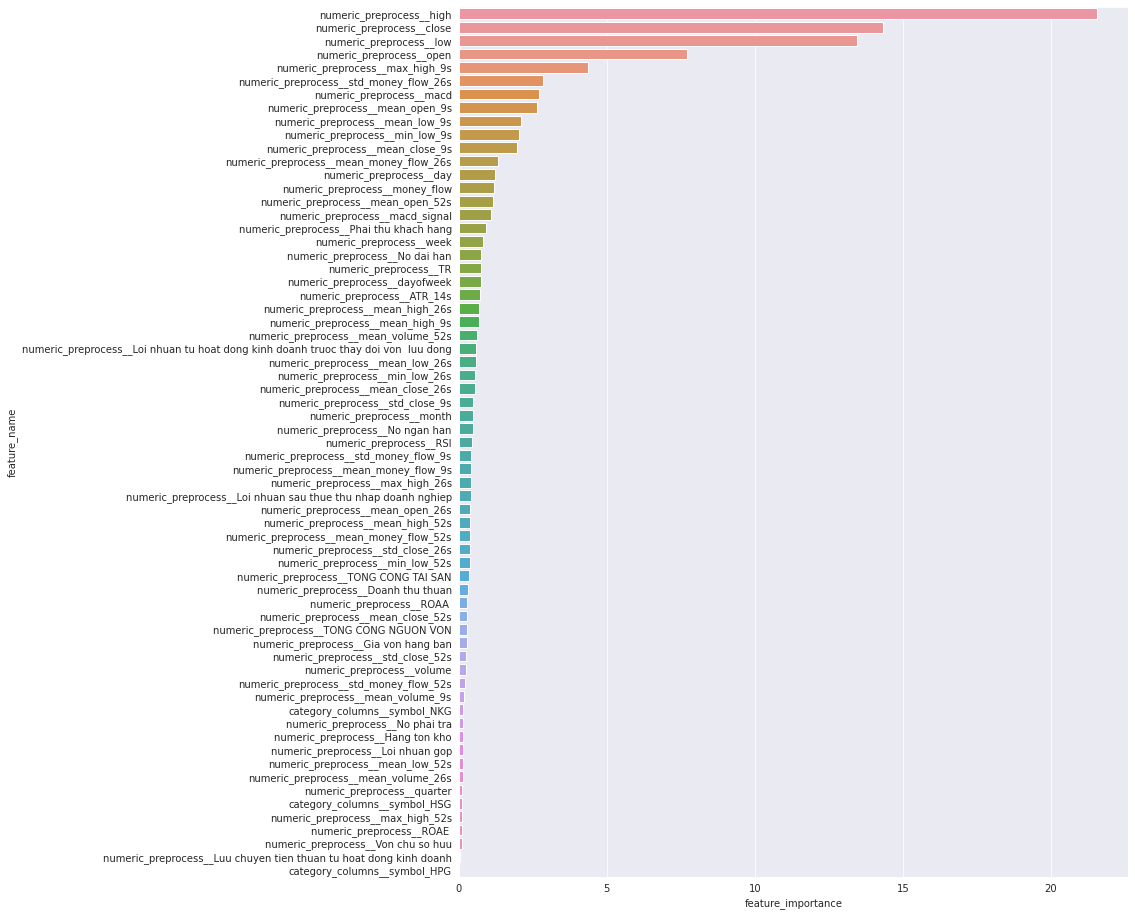

In [59]:
delta = pd.DataFrame()
delta['feature_importance'] =grid.best_estimator_[-1].get_feature_importance()
delta['feature_name'] = grid.best_estimator_[:-1].get_feature_names_out()
delta = delta.sort_values(by = ['feature_importance'], ascending = False)
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize = (12, 16))
sns.barplot(data = delta, x = 'feature_importance', y = 'feature_name', ax = axes)

In [63]:
df.loc[df['target_day_1'].notnull(), 'mode']= 'original'
df.loc[df['target_day_1'].isnull(), 'mode'] = 'model'
X_test =  df.loc[df['target_day_1'].isnull(), feature_columns]
df.loc[df['target_day_1'].isnull(), 'target_day_1'] = grid.best_estimator_.predict(X_test)
df.tail()
# X_test

,date,high,low,open,close,adjust,volume,Tang truong Doanh thu thuan 4 quy lien ke so voi cung ky nam truoc,ROAE,ROAA,Ty le no vay tren von chu,Tang truong Von chu so huu so voi dau nam,Tien va cac khoan tuong duong tien,Tien,Cac khoan tuong duong tien,Cac khoan dau tu tai chinh ngan han,Dau tu ngan han,Du phong giam gia dau tu ngan han,Dau tu giu den ngay dao han,Cac khoan phai thu ngan han,Phai thu khach hang,Tra truoc cho nguoi ban,Phai thu noi bo ngan han,Phai thu theo tien do ke hoach hop dong xay dung,Phai thu ve cho vay ngan han,Cac khoan phai thu khac,Du phong phai thu ngan han kho doi,Tai san thieu cho xu ly,Hang ton kho,Du phong giam gia hang ton kho,Tai san ngan han khac,Chi phi tra truoc ngan han,Thue GTGT duoc khau tru,Thue va cac khoan khac phai thu Nha nuoc,Giao dich mua ban lai trai phieu chinh phu,Tai san dai han,Cac khoan phai thu dai han,Phai thu dai han cua khach hang,Tra truoc dai han nguoi ban,Von kinh doanh o don vi truc thuoc,Phai thu dai han noi bo,Phai thu ve cho vay dai han,Phai thu dai han khac,Du phong phai thu dai han kho doi,Tai san co dinh,Tai san co dinh huu hinh,Nguyen gia TSCDHH,Hao mon TSCDHH,Tai san co dinh thue tai chinh,Nguyen gia TSCDTTC,Hao mon TSCDTTC,Tai san co dinh vo hinh,Nguyen gia TSCDVH,Hao mon TSCDVH,Chi phi xay dung co ban do dang (truoc 2015),Bat dong san dau tu,Nguyen gia bat dong san dau tu,Hao mon bat dong san dau tu,Tai san do dang dai han,"Chi phi san xuat, kinh doanh do dang dai han",Chi phi xay dung co ban do dang,Cac khoan dau tu tai chinh dai han,Dau tu vao cong ty con,"Dau tu vao cong ty lien ket, lien doanh",Dau tu dai han khac,Du phong giam gia dau tu tai chinh dai han,Dau tu dai han giu den ngay dao han,Tai san dai han khac,Chi phi tra truoc dai han,Tai san thue thu nhap hoan lai,"Thiet bi, vat tu, phu tung thay the dai han",Loi the thuong mai,Loi the thuong mai (truoc 2015),TONG CONG TAI SAN,No phai tra,No ngan han,Vay va no ngan han,Phai tra nguoi ban,Nguoi mua tra tien truoc,Thue va cac khoan phai nop Nha nuoc,Phai tra nguoi lao dong,Chi phi phai tra,Phai tra noi bo,Phai tra theo tien do ke hoach hop dong xay dung,"Cac khoan phai tra, phai nop ngan han khac","Quy khen thuong, phuc loi",Doanh thu chua thuc hien ngan han,Du phong phai tra ngan han,Quy binh on gia,No dai han,Phai tra dai han nguoi ban,Nguoi mua tra truoc dai han,Chi phi phai tra dai han,Phai tra noi bo ve von kinh doanh,Phai tra dai han noi bo,Phai tra dai han khac,Vay va no dai han,Trai phieu chuyen doi,Co phieu uu dai,Thue thu nhap hoan lai phai tra,Du phong tro cap mat viec lam,Doanh thu chua thuc hien dai han,Quy phat trien khoa hoc va cong nghe,Du phong phai tra dai han,Von chu so huu,Von va cac quy,Von gop,Co phieu pho thong,Thang du von co phan,Quyen chon chuyen doi trai phieu,Von khac cua chu so huu,Co phieu quy,Chenh lech danh gia lai tai san,Chenh lech ty gia hoi doai,Quy dau tu phat trien,Quy du phong tai chinh,Quy khac thuoc von chu so huu,Loi nhuan sau thue chua phan phoi,Loi nhuan sau thue chua phan phoi luy ke den cuoi ky truoc,Loi nhuan sau thue chua phan phoi ky nay,Loi ich co dong khong kiem soat,Quy ho tro sap xep doanh nghiep,Nguon von dau tu XDCB,Nguon kinh phi va quy khac,"Quy khen thuong, phuc loi (truoc 2010)",Von ngan sach nha nuoc,Nguon kinh phi da hinh thanh TSCD,TONG CONG NGUON VON,Cac khoan giam tru doanh thu,Doanh thu thuan,Gia von hang ban,Loi nhuan gop,Doanh thu hoat dong tai chinh,Chi phi tai chinh,Trong do: Chi phi lai vay,Loi nhuan hoac lo trong cong ty lien ket,Chi phi ban hang,Chi phi quan ly doanh nghiep,Loi nhuan thuan tu hoat dong kinh doanh,Thu nhap khac,Chi phi khac,Loi nhuan khac,Loi nhuan hoac lo trong cong ty lien ket (truoc 2015),Chi phi thue TNDN,Chi phi thue TNDN hien hanh,Chi phi thue TNDN hoan lai,Loi nhuan sau thue thu nhap doanh nghiep,Loi ich cua co dong thieu so,Loi nhuan sau thue cua Cong ty me,Lai co ban tren co phieu,Lai suy giam tren co phieu,Chi phi khau hao tai san co dinh,Phan bo loi the thuong mai,"Du phong giam gia cac khoan dau tu ngan

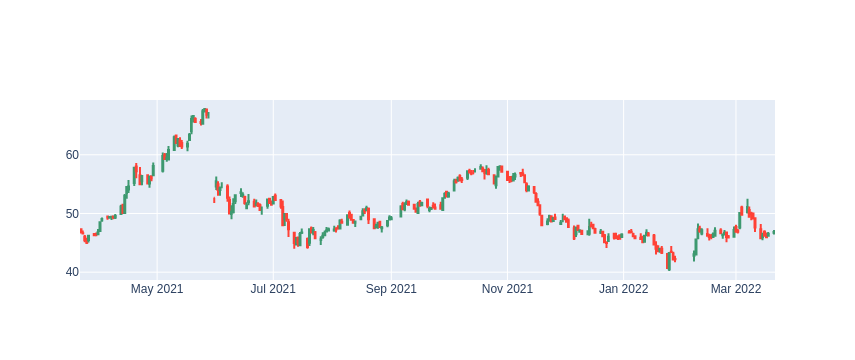

In [66]:
import plotly.graph_objects as go
data = df.loc[df.symbol =='HPG']
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

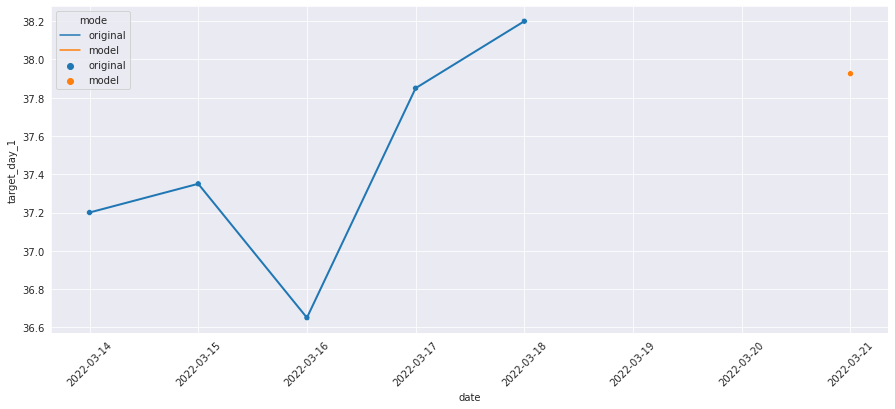

In [80]:
symbol = "HSG"
s_date = str((datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')) - timedelta(days=10)).strftime("%Y-%m-%d"))
data = df.loc[df.symbol ==symbol].loc[df.date>=s_date]
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.set_style("darkgrid")
sns.lineplot(data = data,
            x = 'date', 
            y = 'target_day_1', 
            hue = 'mode',
            # kind = 'line',
            markers=True,
             lw = 2
           )
sns.scatterplot(data = data,
                x = 'date', 
                y = 'target_day_1', 
                hue = 'mode')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import psycopg

# conn = psycopg.connect(dbname = "postgres", user = "user", password = "pass", host = "0.0.0.0", port = "5433")
# cur = conn.cursor()

In [ ]:
# def query(query_string, value_dict=None):
#     try:
#         if value_dict != None:
#             cur.execute(query_string, value_dict)
#         else: 
#             cur.execute(query_string)
#         conn.commit()
#         return cur
#     except Exception as e:
#         print('Error. Rollback connection')
#         conn.rollback()
#         print(e)
#     return cur

In [ ]:
# create_query = """
# CREATE TABLE IF NOT EXISTS D_USER_NAME (
#     USER_ID VARCHAR NOT NULL,
#     NAME VARCHAR NOT NULL
# );
# """
# query(create_query)